# TalkingData Preview

The evaluation metric used here is ROC-AUC, which means:
* This is a binary-classificaiton problem, and our goal is to classify our users into "fraudulent" and "non-fraudulent".
* Unlike the metric of LogLoss, the ROC-AUC depends on how well you separate the two classes. As a result, the model's probability results won't affect the score. 

### Content
0. [Data Import](#data_import)
1. [Data Overview & EDA](#data_overview)
    * [General](#dv_general)
    * [Individual Variable](#dv_iv)
    * [Click Time](#dv_ct)
    
2. [Data Engineering](#data_engineering)
3. Modeling & Prediction

## Data Import <a id="data_import"></a>

In [1]:
cd "/Users/lli2/Git/kaggle/TalkingData_AdTracking"

/Users/lli2/Git/kaggle/TalkingData_AdTracking


In [47]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os 

pal = sns.color_palette()

%matplotlib inline

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = '/Users/lli2/Git/kaggle_data'
for f in os.listdir(data_dir):
    if 'zip' not in f:
        print(f.ljust(20) + str(round(os.path.getsize(data_dir + '/' + f)/1000000, 2)) + " MB")

test.csv            863.27 MB
train.csv           7537.65 MB


## Data Overview & EDA <a id="data_overview"></a>

In [288]:
df_train = pd.read_csv(data_dir + '/train.csv', nrows=10000000)
#df_test = pd.read_csv(data_dir + '/test.csv', nrows=1000000)

In [289]:
common_names = df_train.columns.intersection(df_test.columns).values

In [291]:
# df_train.describe()

In [292]:
df_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [293]:
# df_test = df_test[common_names]
# df_test.head()

#### Looking at the columns
* ip: ip address of click
* app: app id for marketing
* device: device type id of user mobile phone 
* os: os version id of user mobile phone
* channel: channel id of mobile ad publisher
* click_time: timestamp of click
* attributed_time: if user download the app for after clicking an ad, this is the time of the app download
* is_attributed: the target that is to be predicted, indicating the app was downloaded

#### Data Type Transformation

DateTime

In [352]:
dat_var = ['click_time', 'attributed_time']
print(dat_var)
for dv in dat_var:
    df_train[dv] = pd.to_datetime(df_train[dv])

['click_time', 'attributed_time']


Categorical

In [353]:
cat_var = set(df_train.columns.values) - set(dat_var)
print(cat_var)
for cv in cat_var:
    df_train[cv] = df_train[cv].astype('category')

{'channel', 'is_attributed', 'os', 'app', 'ip', 'device'}


Check the data type of each column

In [356]:
df_train.dtypes

ip                       category
app                      category
device                   category
os                       category
channel                  category
click_time         datetime64[ns]
attributed_time    datetime64[ns]
is_attributed            category
dtype: object

Average Conversion Rate

In [360]:
download_rate = df_train['is_attributed'].astype('int').mean()
download_rate
print("The download rate of the training data is {}% amoung 10M data.".format(round(download_rate*100,2)))

The download rate of the training data is 0.19% amoung 10M data.


### Data Visualization - General <a id="dv_general"></a>

#### Unique number of records in each field

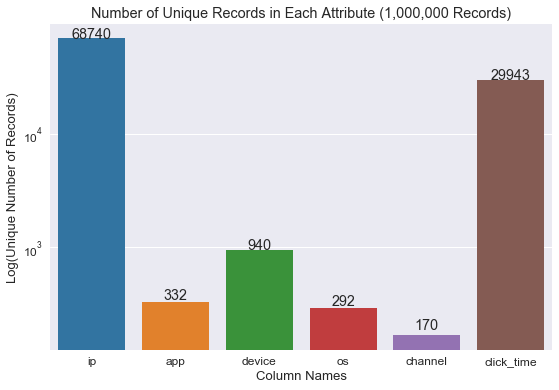

In [294]:
unique_count = [len(df_train[col].unique()) for col in common_names]

plt.figure(figsize=(9,6))
sns.set(font_scale=1.2)
ax = sns.barplot(x=common_names, y=unique_count, palette=pal, log=True)
ax.set(xlabel="Column Names", 
       ylabel="Log(Unique Number of Records)", 
       title="Number of Unique Records in Each Attribute (1,000,000 Records)")

for p, uniq in zip(ax.patches, unique_count):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,
            p.get_height() + 20,
            uniq,
            ha="center")

plt.show();

### Data Visualization - Individual Variable <a id="dv_iv"></a>

#### Variable - IP

* Frequency of IPs

68740
Variable 'ip': | Unique values: 68740 | Highest Frequenct: 51711 | Lowest Frequency: 1
Frequency>=100: 34.67% | Frequency>=1000: 1.68% | Frequency>=10000: 0.04%
Note: More than 50% of IPs showed up less than 10 times.


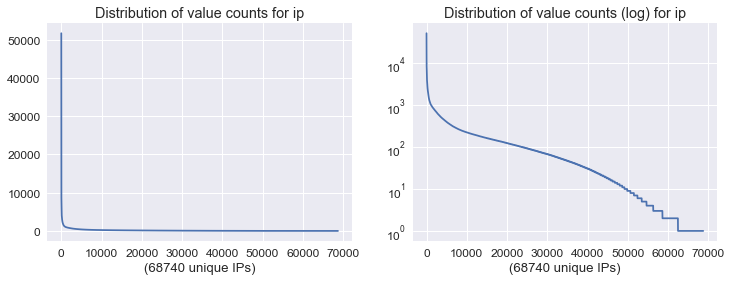

In [310]:
var_viz = 'ip'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1] # the frequency of each unique IP
print(len(sorted_count)) # 68740 unique IPs


fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(sorted_count)
#ax.set_yscale('log')
ax.set(title="Distribution of value counts for {}".format(var_viz),
       xlabel="({unique_cnt} unique {var}s)".format(unique_cnt=len(sorted_count), var=var_viz.upper()));

ax = fig.add_subplot(1, 2, 2)
ax.plot(sorted_count)
ax.set_yscale('log')
ax.set(title="Distribution of value counts (log) for {}".format(var_viz),
       xlabel="({unique_cnt} unique {var}s)".format(unique_cnt=len(sorted_count), var=var_viz.upper()));


print("Variable '{a}': | Unique values: {b} | Highest Frequenct: {c} | Lowest Frequency: {d}".format(a=var_viz, 
                                                                                                     b=len(sorted_count), 
                                                                                                     c=sorted_count[0], 
                                                                                                     d=sorted_count[-1]))

print("Frequency>=100: {a}% | Frequency>=1000: {b}% | Frequency>=10000: {c}%".format(a=str(round((sorted_count>=100).mean()*100, 2)), 
                                                                                  b=str(round((sorted_count>=1000).mean()*100, 2)), 
                                                                                  c=str(round((sorted_count>=10000).mean()*100, 2))))

print("Note: More than 50% of IPs showed up less than 10 times.")


* Number of Unique IP for Each Frequency Bin

For every 50 Frequency number, how many records occurance time is equal to it. For example, how many unique IPs have an occurance of 1-5 times.

Note: 
Rare IP will show up more than 2000 times and even rare to show up more than 6000 times. 
They could be some fraudulent or outliers.


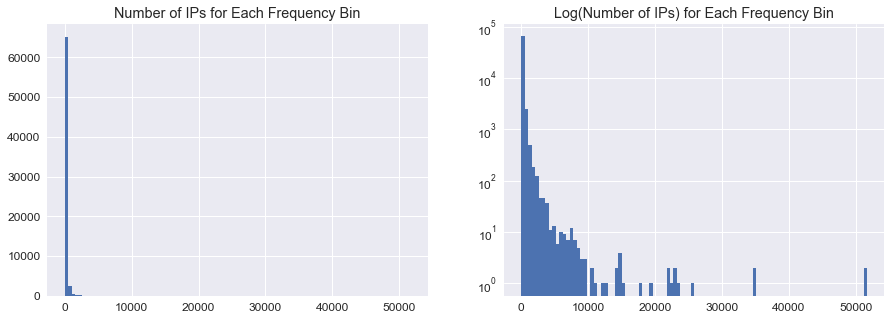

In [297]:
var_viz = 'ip'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1] # the frequency of each unique IP

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1)
plt.hist(sorted_count, bins=100) # Counts of Unique IP for a frequency range
ax.set(title="Number of {}s for Each Frequency Bin".format(var_viz.upper()));

ax = fig.add_subplot(1, 2, 2)
plt.hist(sorted_count, bins=100) # Counts of Unique IP for a frequency range
ax.set_yscale('log', nonposy='clip') # nonposy: log(1) = 0 --> clipped to a very small positive number
ax.set(title="Log(Number of {}s) for Each Frequency Bin".format(var_viz.upper()));


print("Note: \nRare IP will show up more than 2000 times and even rare to show up more than 6000 times. \nThey could be some fraudulent or outliers.")




* Conversion Rate By IP

In [372]:
ip_value_counts = df_train['ip'].value_counts().reset_index(name='counts')
ip_value_counts.columns = ['ip', 'counts']
ip_value_counts.head(3)

,ip,counts
0,73516,51711
1,73487,51215
2,5314,35073


In [374]:
# Convert is_attributed back to numeric for rate calculation
df_train['is_attributed'] = df_train['is_attributed'].astype('int')

In [443]:
ip_conversion_prop = df_train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed',ascending=False).reset_index(drop=True)
ip_conversion_prop.columns = ['ip', 'conversion_rate']
ip_conversion_cnt = df_train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed',ascending=False).reset_index(drop=True)
ip_conversion_cnt.columns = ['ip', 'counts']

ip_conversion = ip_conversion_prop.merge(ip_conversion_cnt, on='ip', how='left').sort_values('counts',ascending=False).reset_index(drop=True)
ip_conversion.head()

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,ip,conversion_rate,counts
0,73516,0.001044,51711
1,73487,0.001093,51215
2,5314,0.000741,35073
3,5348,0.000686,35004
4,53454,0.000118,25381


In [435]:
ip_conversion.shape, ip_conversion_prop.shape, ip_conversion_cnt.shape

((68740, 2), (68740, 2), (68740, 2))

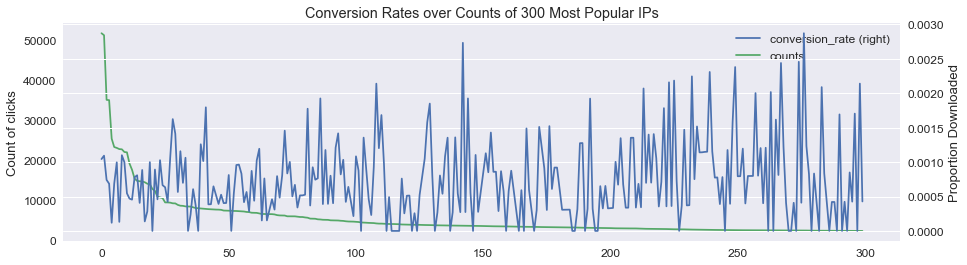

In [452]:
ax = ip_conversion[:300].plot(secondary_y='conversion_rate', figsize=(15,4))
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

The shape of conversion rate is noisy along with the IP count trend.

#### Variable - APP

* Frequency of IPs

332
Variable app | Unique Value: 332 | Highest Frequency: 1291185 | Lowest Frequency: 1
Frequency>=100: 36.45% | Frequency>=10000: 8.43% | Frequency>=100000: 5.72%
Note: The distribution of frequencies of apps makes sense.


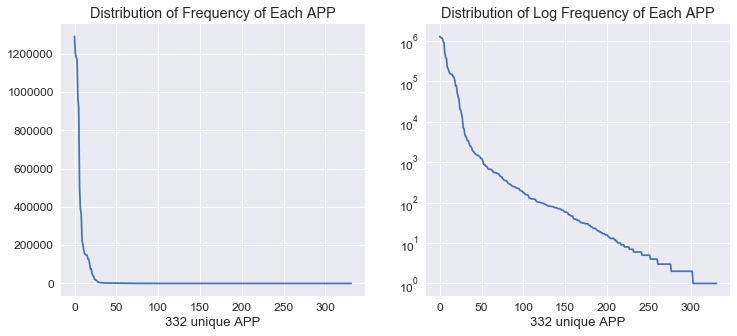

In [453]:
var_viz = 'app'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]
print(len(sorted_count)) # 332 unique APPs

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
ax.plot(sorted_count)
ax.set(title="Distribution of Frequency of Each APP", 
       xlabel="{} unique {}".format(len(sorted_count), var_viz.upper()));


ax = fig.add_subplot(122)
ax.plot(sorted_count)
ax.set_yscale('log')
ax.set(title="Distribution of Log Frequency of Each APP", 
       xlabel="{} unique {}".format(len(sorted_count), var_viz.upper()));


print("Variable {a} | Unique Value: {b} | Highest Frequency: {c} | Lowest Frequency: {d}".format(a=var_viz,
                                                                                                 b=len(sorted_count),
                                                                                                 c=sorted_count[0],
                                                                                                 d=sorted_count[-1]))

print("Frequency>=100: {a}% | Frequency>=10000: {b}% | Frequency>=100000: {c}%".format(a=round((sorted_count>=100).mean()*100,2),
                                                                                    b=round((sorted_count>=10000).mean()*100,2),
                                                                                    c=round((sorted_count>=100000).mean()*100,2)))

print("Note: The distribution of frequencies of apps makes sense.")

* Number of Unique APP for Each Frequency Bin

Note: It seems APP is a 'winner-takes-all' game. 
The majority of APPs only have 1 frequency and some could get frequency larger than 80000.


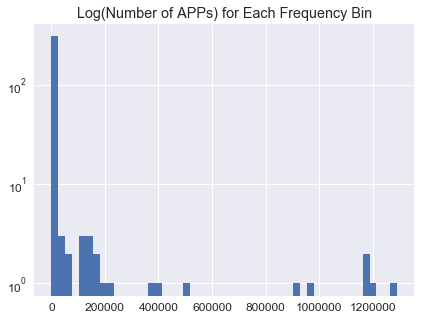

In [454]:
var_viz = 'app'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]

fig=plt.figure(figsize=(15, 5))
ax=fig.add_subplot(121)
plt.hist(sorted_count, bins=50)
ax.set_yscale('log', nonposy='clip')
ax.set(title="Log(Number of {}s) for Each Frequency Bin".format(var_viz.upper()),
       )
;


print("Note: It seems APP is a 'winner-takes-all' game. \nThe majority of APPs only have 1 frequency and some could get frequency larger than 80000.")



* Conversion Rate By APP

In [461]:
app_counts = df_train['app'].value_counts().reset_index()
app_counts.columns = ['app', 'counts']
app_counts.head()

,app,counts
0,12,1291185
1,2,1202534
2,15,1181585
3,3,1170412
4,9,966839


In [462]:
# Convert is_attributed back to numeric for rate calculation
df_train['is_attributed'] = df_train['is_attributed'].astype('int')

In [474]:
app_conversion_rate = df_train[['app','is_attributed']].groupby(by='app', as_index=False).count()
app_conversion_rate.columns = ['app','counts']
app_conversion_counts = df_train[['app','is_attributed']].groupby(by='app', as_index=False).mean()
app_conversion_counts.columns = ['app','conversion_rate']
app_conversion_counts.head()

,app,conversion_rate
0,0,0.336842
1,1,0.000350
2,2,0.000388
3,3,0.000630
4,4,0.000000


In [485]:
app_conversion = app_conversion_rate.merge(app_conversion_counts, on='app', how='inner').sort_values('counts',ascending=False).reset_index(drop=True)
app_conversion.head()

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,app,counts,conversion_rate
0,12,1291185,0.000140
1,2,1202534,0.000388
2,15,1181585,0.000277
3,3,1170412,0.000630
4,9,966839,0.000869


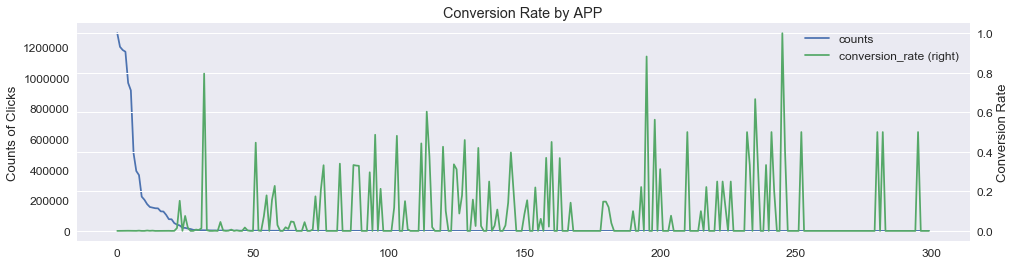

In [494]:
ax = app_conversion[:300].plot(secondary_y='conversion_rate', figsize=(16,4))
ax.set(title="Conversion Rate by APP",
       ylabel="Counts of Clicks")
plt.ylabel("Conversion Rate");

For the top 25 most frequent click Apps, they have high number of clicks but near-zero conversion rate. 

#### Variable - Device

* Frequency of Devices

940
Variable: 'device' | Unique Values: 940 | Highest Frequency: 9381146 | Lowest Frequency: 1
Frequency>=100: 2.34% | Frequency>=1000: 0.53% | Frequency>=10000: 0.43%
Note: Half of the devices have only 1 record.


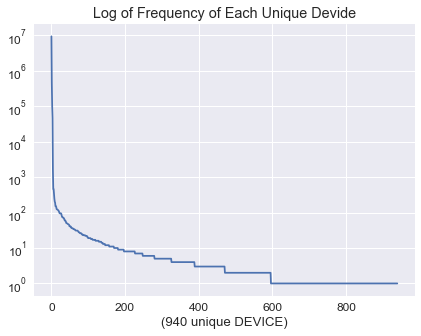

In [308]:
var_viz = 'device'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]
print(len(sorted_count)) # 940 unique devices

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(sorted_count)
ax.set_yscale('log')
ax.set(title = "Log of Frequency of Each Unique Devide",
       xlabel = "({} unique {})".format(len(sorted_count), var_viz.upper()));

print("Variable: '{a}' | Unique Values: {b} | Highest Frequency: {c} | Lowest Frequency: {d}".format(a=var_viz,
                                                                                                     b=len(sorted_count),
                                                                                                     c=sorted_count[0],
                                                                                                     d=sorted_count[-1]))

print("Frequency>=100: {a}% | Frequency>=1000: {b}% | Frequency>=10000: {c}%".format(a=round((sorted_count>=100).mean()*100, 2),
                                                                               b=round((sorted_count>=1000).mean()*100, 2),
                                                                               c=round((sorted_count>=10000).mean()*100, 2)))

print("Note: Half of the devices have only 1 record.")

* Number of Unique Device for Each Frequency Bin

Note: Only few device have a frequency larger than 10. 


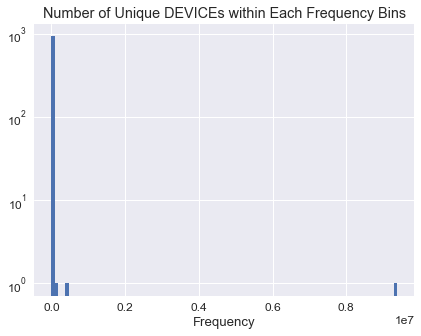

In [305]:
var_viz = 'device'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plt.hist(sorted_count, bins=100)
ax.set_yscale('log', nonposy='clip')
ax.set(title="Number of Unique {}s within Each Frequency Bins".format(var_viz.upper()),
       xlabel="Frequency");

print("Note: Only few device have a frequency larger than 10. ")

* Conversion Rate By Device

In [496]:
device_counts = df_train['device'].value_counts().sort_values(ascending=False).reset_index(drop=True)
print(len(device_counts))
device_counts.head()

940


0    9381146
1     456617
2     104393
3      46476
4       1618
Name: device, dtype: int64

In [502]:
device_conversion_rate = df_train[['device','is_attributed']].groupby('device').mean().reset_index()
device_conversion_rate.columns = ['device','conversion_rate']
device_conversion_counts = df_train[['device','is_attributed']].groupby('device').count().reset_index()
device_conversion_counts.columns = ['device','counts']

device_conversion = device_conversion_rate.merge(device_conversion_counts, on='device', how='inner').sort_values('counts',ascending=False).reset_index(drop=True)
device_conversion.head()


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,device,conversion_rate,counts
0,1,0.001326,9381146
1,2,0.000208,456617
2,3032,0.000000,104393
3,0,0.091961,46476
4,59,0.001236,1618


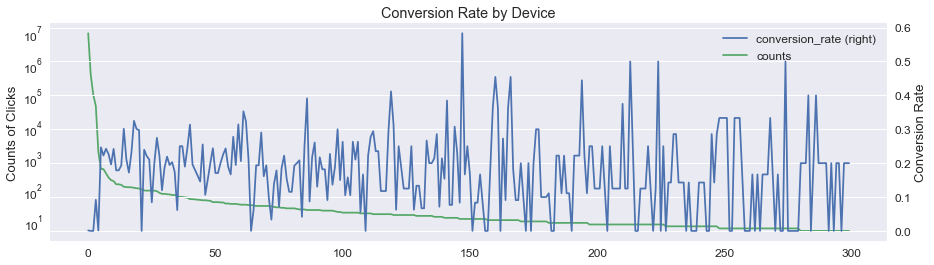

In [507]:
ax = device_conversion[:300].plot(secondary_y='conversion_rate', figsize=(15,4))
ax.set_yscale('log')
ax.set(title="Conversion Rate by Device",
       ylabel="Counts of Clicks")
plt.ylabel("Conversion Rate");

#### Variable - OS

* Frequency of OS

292


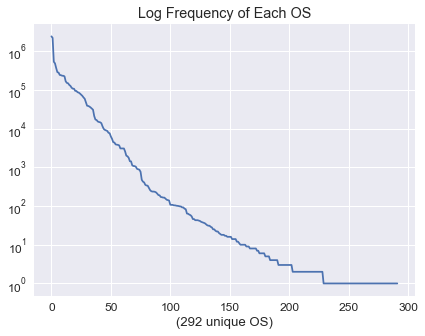

In [312]:
var_viz = 'os'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]
print(len(sorted_count)) # 292 unique OS

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(sorted_count)
ax.set_yscale('log')
ax.set(title="Log Frequency of Each OS",
       xlabel="({} unique {})".format(len(sorted_count), var_viz.upper()));

* Number of Unique OS for Each Frequency Bin

Note: It's possible that the 'rare' OSs are associated with those rare devices or IPs.


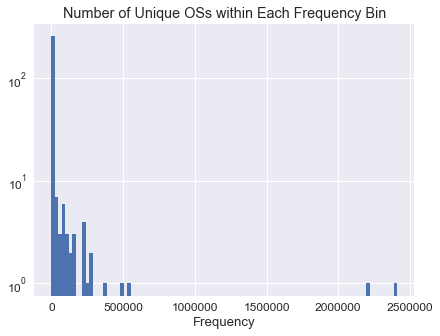

In [315]:
var_viz = 'os'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plt.hist(sorted_count, bins=100)
ax.set_yscale('log', nonposy='clip')
ax.set(title="Number of Unique {}s within Each Frequency Bin".format(var_viz.upper()),
       xlabel="Frequency");


print("Note: It's possible that the 'rare' OSs are associated with those rare devices or IPs.")

* Conversion Rate By OS

In [511]:
os_conversion_rate = df_train[['os','is_attributed']].groupby('os').mean().reset_index()
os_conversion_rate.columns = ['os','conversion_rate']
os_conversion_counts = df_train[['os','is_attributed']].groupby('os').count().reset_index()
os_conversion_counts.columns = ['os','counts']

os_conversion = os_conversion_rate.merge(os_conversion_counts, on='os', how='inner').sort_values('counts',ascending=False).reset_index(drop=True)
print(os_conversion.shape)
os_conversion.head()


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

(292, 3)


Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,os,conversion_rate,counts
0,19,0.001489,2410148
1,13,0.001271,2199778
2,17,0.001155,531695
3,18,0.001115,483602
4,22,0.001729,365576


Text(0,0.5,'Conversion Rate')

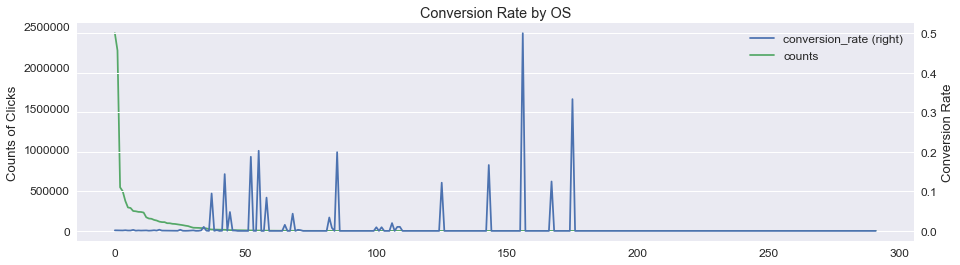

In [512]:
ax = os_conversion[:300].plot(secondary_y='conversion_rate', figsize=(15,4))
ax.set(title="Conversion Rate by OS",
       ylabel="Counts of Clicks")
plt.ylabel("Conversion Rate")

#### Variable - Channel

* Frequency of Channel

170



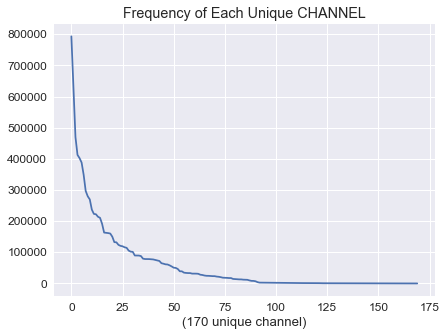

In [311]:
var_viz = 'channel'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]
print(len(sorted_count)) # 170 unique channels

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(sorted_count)
ax.set(title="Frequency of Each Unique {}".format(var_viz.upper()),
       xlabel="({} unique {})".format(len(sorted_count), var_viz));

print("")


* Number of Unique Channel for Each Frequency Bin

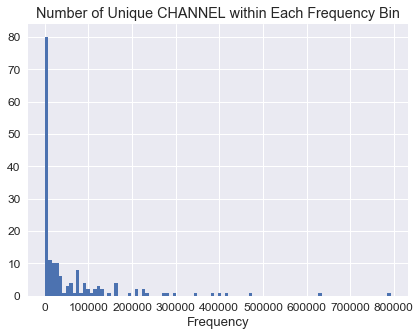

In [316]:
var_viz = 'channel'

sorted_count = np.sort(df_train[var_viz].value_counts().as_matrix())[::-1]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plt.hist(sorted_count, bins=100)
ax.set(title="Number of Unique {} within Each Frequency Bin".format(var_viz.upper()),
       xlabel="Frequency".format(len(sorted_count), var_viz));

print("")

* Conversion Rate By Channel

In [513]:
channel_conversion_rate = df_train[['channel','is_attributed']].groupby('channel').mean().reset_index()
channel_conversion_rate.columns = ['channel','conversion_rate']
channel_conversion_counts = df_train[['channel','is_attributed']].groupby('channel').count().reset_index()
channel_conversion_counts.columns = ['channel','counts']

channel_conversion = channel_conversion_rate.merge(channel_conversion_counts, on='channel', how='inner').sort_values('counts',ascending=False).reset_index(drop=True)
print(channel_conversion.shape)
channel_conversion.head()


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

(170, 3)


Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,channel,conversion_rate,counts
0,245,0.000105,793105
1,134,0.000558,630888
2,259,0.000653,469845
3,477,0.000073,412559
4,121,0.000323,402226


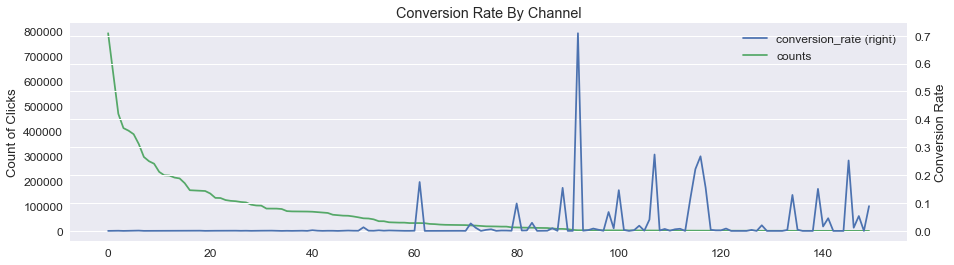

In [515]:
ax = channel_conversion[:150].plot(secondary_y='conversion_rate', figsize=(15,4))
ax.set(title = "Conversion Rate By Channel",
       ylabel = "Count of Clicks")
plt.ylabel("Conversion Rate");

Very interesting that the top 40 channels has extremely low conversion rate.

### Data Visualization - Click Time <a id="dv_ct"></a>

To check the pattern based on time, we need to use the random sampled train date set...

In [519]:
df_train_sample = pd.read_csv("/Users/lli2/Git/kaggle_data/train_sample.csv")
print(df_train_sample.shape)
df_train_sample.head(3)

(100000, 8)


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0


In [549]:
sample_hour = df_train_sample[['click_time','is_attributed']]
sample_hour['click_date_hour'] = pd.to_datetime(sample_hour['click_time']).dt.round('H')
sample_hour['click_hour'] = pd.to_datetime(sample_hour['click_time']).dt.hour

sample_hour.head(3)

,click_time,is_attributed,click_date_hour,click_hour
0,2017-11-07 09:30:38,0,2017-11-07 10:00:00,9
1,2017-11-07 13:40:27,0,2017-11-07 14:00:00,13
2,2017-11-07 18:05:24,0,2017-11-07 18:00:00,18


#### Overall

2017-11-09 05:00:00    2156
2017-11-08 14:00:00    2030
2017-11-08 15:00:00    1965
Name: click_date_hour, dtype: int64


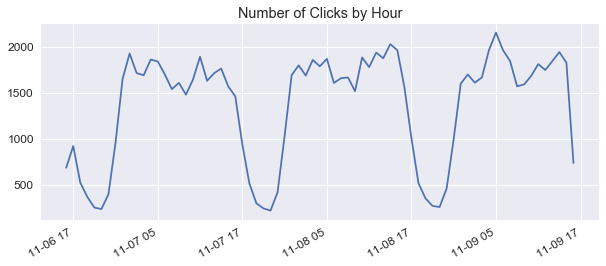

In [545]:
ax = sample_hour['click_date_hour'].value_counts().plot(figsize=(10,4))
ax.set(title='Number of Clicks by Hour');
print(sample_hour['click_date_hour'].value_counts().head(3))

                     is_attributed
click_date_hour                   
2017-11-06 16:00:00              0
2017-11-06 17:00:00              2
2017-11-06 18:00:00              0


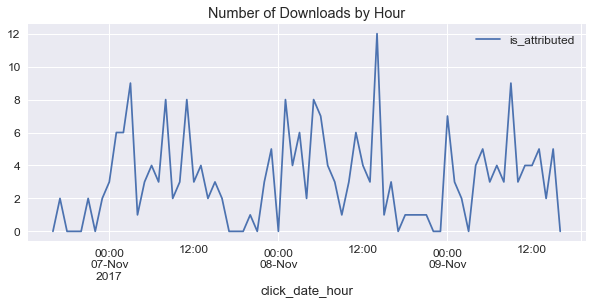

In [547]:
ax = sample_hour[['click_date_hour','is_attributed']].groupby('click_date_hour').sum().plot(figsize=(10,4))
ax.set(title="Number of Downloads by Hour");
print(sample_hour[['click_date_hour','is_attributed']].groupby('click_date_hour').sum().head(3))

                     is_attributed
click_date_hour                   
2017-11-06 16:00:00       0.000000
2017-11-06 17:00:00       0.002172
2017-11-06 18:00:00       0.000000


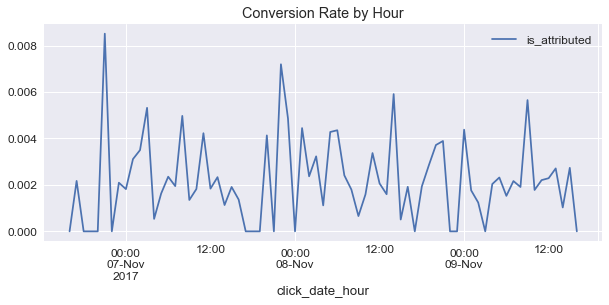

In [548]:
ax = sample_hour[['click_date_hour','is_attributed']].groupby('click_date_hour').mean().plot(figsize=(10,4))
ax.set(title="Conversion Rate by Hour");
print(sample_hour[['click_date_hour','is_attributed']].groupby('click_date_hour').mean().head(3))

#### Hourly Aggregation

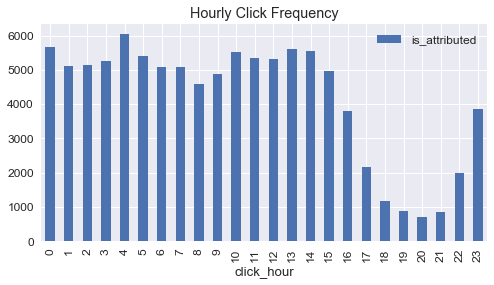

In [573]:
ax = sample_hour[['click_hour','is_attributed']].groupby('click_hour',as_index=True).count().plot(kind='bar',figsize=(8,4));
ax.set(title="Hourly Click Frequency");


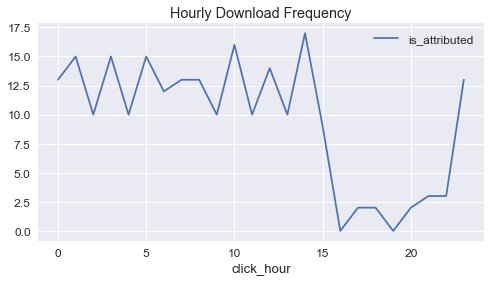

In [574]:
ax = sample_hour[['click_hour','is_attributed']].groupby('click_hour',as_index=True).sum().plot(figsize=(8,4))
ax.set(title="Hourly Download Frequency");


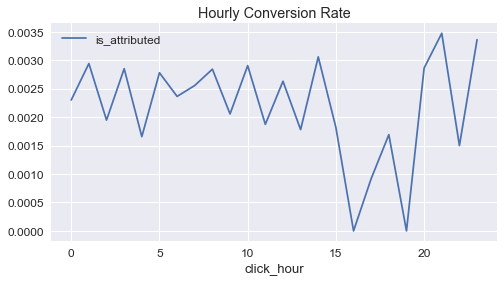

In [578]:
ax = sample_hour[['click_hour','is_attributed']].groupby('click_hour',as_index=True).mean().plot(figsize=(8,4))
ax.set(title="Hourly Conversion Rate");

[Text(0.5,1,'Hourly Conversion Rate')]

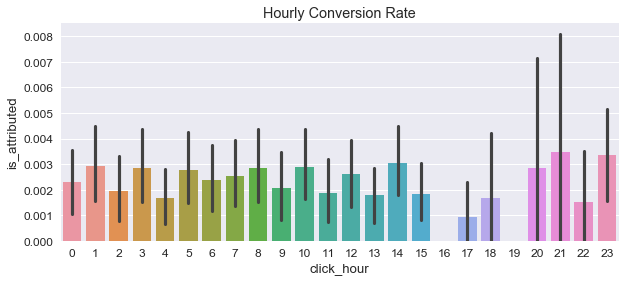

In [581]:
plt.figure(figsize=(10,4))
ax = sns.barplot('click_hour', 'is_attributed', data=sample_hour)
ax.set(title="Hourly Conversion Rate");
# by default, "estimator" in barplot is "mean"
# error bar: 1 standard division

## Data Engineering <a id="data_engineering"></a>

###### Missing data

In [587]:
df_train_sample.isnull().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

In [586]:
df_train_sample['is_attributed'].mean()

0.00227

###### IP Frequency Group